<a href="https://colab.research.google.com/github/a-pujahari/EVA7/blob/main/Session5/EVA7_Session_5_Drill_Down_Part_3_Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Target

1. Add Batch Normalization to improve rate of convergence and overall accuracy after 15 epochs.

# Results

Total parameters: 7,624

Best Training Accuracy: 99.32% - 15th Epoch

Best Testing Accuracy: 99.28% - 14th Epoch

# Analysis

Addition of Batch Normalization quickens pace of accuracy increase through the epochs (added contrast to all channels due to BN helps).

Very slight overfitting is observed with a difference of ~0.05 between training and testing accuracies in the last 3 epochs. Next step should be to add dropout to regularize the NN and reduce overfitting.

## Specify Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

## Download Dataset & Specify Transformations

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Device & Dataloader Specifications

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


## Model

In [5]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), ## Expand number of channels
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.transblock1 = nn.Sequential(
            nn.MaxPool2d(2,2), ## Squeeze
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False), ## Pointwise Convolution
        ) # output_size = 12
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), ## Expand number of channels
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False), ## Expand number of channels
            nn.ReLU(),
            nn.BatchNorm2d(24)
        ) # output_size = 8
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8) ## Global Average Pooling
        ) # output_size = 1

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), ## Increase (expand) number of channels
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False), ## Reduce down number of channels
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) 

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False), ## Reduce number of channels to output required
        ) 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transblock1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)        
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Summary

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]             128
            Conv2d-9           [-1, 16, 10, 10]           1,152
             ReLU-10           [-1, 16, 10, 10]               0
      BatchNorm2d-11           [-1, 16, 10, 10]              32
           Conv2d-12             [-1, 24, 8, 8]           3,456
             ReLU-13             [-1, 24, 8, 8]               0
      BatchNorm2d-14             [-

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Define Train & Test Functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Train & Test Model

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.16191762685775757 Batch_id=937 Accuracy=93.83: 100%|██████████| 938/938 [00:55<00:00, 16.92it/s]



Test set: Average loss: 0.0633, Accuracy: 9800/10000 (98.00%)

EPOCH: 2


Loss=0.14946022629737854 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:54<00:00, 17.13it/s]



Test set: Average loss: 0.0786, Accuracy: 9760/10000 (97.60%)

EPOCH: 3


Loss=0.29730308055877686 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:54<00:00, 17.07it/s]



Test set: Average loss: 0.0412, Accuracy: 9871/10000 (98.71%)

EPOCH: 4


Loss=0.02252510003745556 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:55<00:00, 16.89it/s]



Test set: Average loss: 0.0381, Accuracy: 9886/10000 (98.86%)

EPOCH: 5


Loss=0.03430664911866188 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:56<00:00, 16.60it/s]



Test set: Average loss: 0.0383, Accuracy: 9879/10000 (98.79%)

EPOCH: 6


Loss=0.007675621658563614 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:56<00:00, 16.61it/s]



Test set: Average loss: 0.0328, Accuracy: 9896/10000 (98.96%)

EPOCH: 7


Loss=0.00798933394253254 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:56<00:00, 16.52it/s]



Test set: Average loss: 0.0291, Accuracy: 9903/10000 (99.03%)

EPOCH: 8


Loss=0.04528769850730896 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:58<00:00, 16.17it/s]



Test set: Average loss: 0.0290, Accuracy: 9905/10000 (99.05%)

EPOCH: 9


Loss=0.04394622519612312 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:57<00:00, 16.23it/s]



Test set: Average loss: 0.0287, Accuracy: 9910/10000 (99.10%)

EPOCH: 10


Loss=0.038928091526031494 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:57<00:00, 16.41it/s]



Test set: Average loss: 0.0274, Accuracy: 9920/10000 (99.20%)

EPOCH: 11


Loss=0.07518704235553741 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:57<00:00, 16.38it/s]



Test set: Average loss: 0.0268, Accuracy: 9913/10000 (99.13%)

EPOCH: 12


Loss=0.013213617727160454 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:56<00:00, 16.68it/s]



Test set: Average loss: 0.0266, Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.007449124474078417 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:56<00:00, 16.53it/s]



Test set: Average loss: 0.0254, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.013343668542802334 Batch_id=937 Accuracy=99.29: 100%|██████████| 938/938 [00:55<00:00, 16.79it/s]



Test set: Average loss: 0.0250, Accuracy: 9928/10000 (99.28%)

EPOCH: 15


Loss=0.13747689127922058 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [00:55<00:00, 16.91it/s]



Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.26%)



Text(0.5, 1.0, 'Test Accuracy')

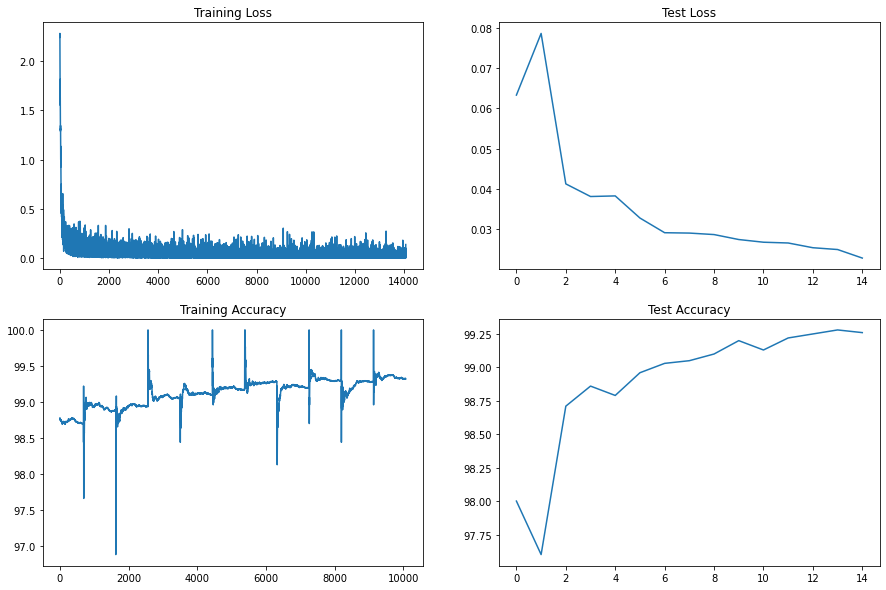

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")